In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [2]:
'''
Creating an atlas
'''
deep_reload(nice)

rng = np.random.default_rng(26893751)

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
    'create_using': nx.DiGraph
}

atlas = nice.graph.nmu_graph(100, 3, **kw)

for source, _adj in atlas._adj.items():

    atlas._node[source]['population'] = 10 ** rng.uniform(2, 6) / 1e6
    
    for target, edge in _adj.items():

        speed = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / speed
        edge['energy'] = 500 * edge['distance']
        edge['cost'] = edge['time']

In [3]:
'''
Selecting places and stations
'''
deep_reload(nice)

n_places = 15
n_stations = 45

rng = np.random.default_rng(26589763514)

places = list(
    rng.choice(atlas.nodes, replace = False, size = n_places)
)

stations = list(
    rng.choice(
        list(set(atlas.nodes) - set(places)), replace = False, size = n_stations
    )
)

In [4]:
'''
Creating a Vehicle
'''
deep_reload(nice)

kw = {
    'capacity': 55 * 3.6e6,
    'fields': ['time', 'distance', 'energy', 'cost']
}

vehicle = nice.optimization.Vehicle(**kw)

graph = vehicle.transform(atlas, places + stations)

In [5]:
deep_reload(nice)

paths = nice.graph.get_paths(
    graph, terminals = places, k = 25, weight = 'time',
)

 [------------------->] 100.00%, 119.59 it/s, 0.13 s elapsed, 0.00 s remaining

In [6]:
'''
Places
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
    'friction_function': lambda x: 1,
}

graph = nice.demand.demand(graph, places, **kw)

In [7]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
rho = np.concatenate(
    (
        np.linspace(0, .5, 2),
        np.linspace(.51, .99, 10),
        np.linspace(.991, .999, 10)
    )
)

delta = 10

for station in stations:

    node = graph._node[station]
    node['port_count'] = rng.integers(0, 20)

    power = 80 * 1e3
    m = 1 / (energy / power)
    n = node['port_count']

    lower_bound = n
    upper_bound = n + delta if n > 3 else n
    c = list(range(lower_bound, upper_bound + 1, 1))

    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    counts = np.array([c for c in c])
    expenditure = np.array([c - n for c in c])

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * 3600 / (1 / volumes))
    graph._node[station]['counts'] = counts
    graph._node[station]['expenditures'] = expenditure

In [8]:
'''
Adding classes and Building the network
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']
        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 0.015436410903930664
Sets Built: 0.09521126747131348
Parameters Built: 0.01627826690673828
Variables Built: 0.026346921920776367
Constraints Built: 0.04350709915161133
Expenditure Built: 0.0010266304016113281
Objective Built: 0.00313568115234375


In [9]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 100

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 6.813321113586426
Results Collected: 0.010384559631347656
Objective Value: 22.40506469465123


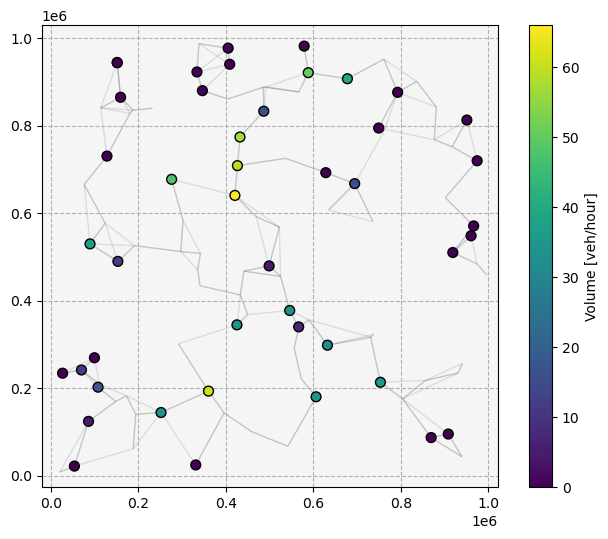

In [10]:
'''
Plotting station volume
'''
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for station in stations:
    
    node = solution._node[station]

    node['volume_h'] = node.get('volume', 0) * 3600
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['delta'] > 0]
        ),
        'selection': stations,
        'field': 'volume_h',
        'colorbar': {
            'label': 'Volume [veh/hour]',
        },
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

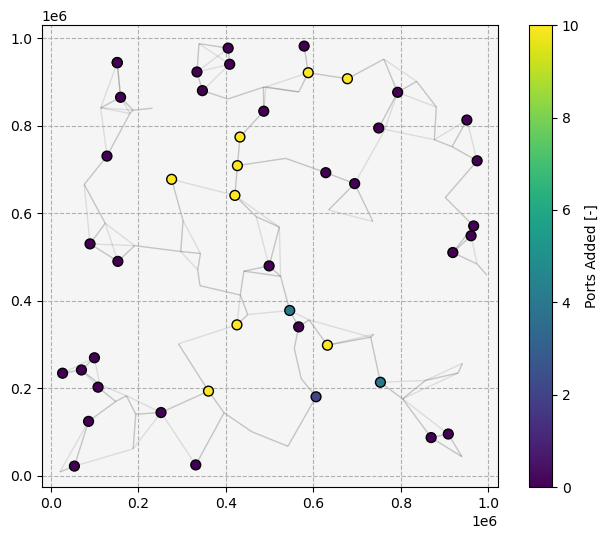

In [11]:
'''
Plotting ports added
'''
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for station in stations:
    
    node = solution._node[station]
    
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['delta'] > 0]
        ),
        'selection': stations,
        'field': 'delta',
        'colorbar': {
            'label': 'Ports Added [-]',
        },
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')